In [2]:
from model import ImageAudioSiameseNetwork
from loss import TripletLoss
from dataset import ImageAudioDataset
from data_prep import prepare_zsl_split_img_audio
from transforms import get_transforms
from model_manager import ModelManager
from utils import *

In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
siamese_network = ImageAudioSiameseNetwork().to(device)
triplet_loss = TripletLoss(0.5).to(device)
img_transforms, mel_transform = get_transforms()

In [8]:
optimizer_siamese = optim.Adam(siamese_network.parameters(), lr=0.01)
exp_lr_scheduler = ReduceLROnPlateau(
    optimizer_siamese, 
    mode='min', 
    factor=0.2, 
    patience=5, 
    verbose=True
)

In [9]:
curr_model = ModelManager(
    siamese_network, 
    triplet_loss, 
    optimizer_siamese, 
    exp_lr_scheduler, 
    device
)

In [10]:
curr_model.load_model('./checkpoints/img_audio_221128/w_ep-00195_l-0.0908.pth')

Loading model done: ./checkpoints/img_audio_221128/w_ep-00195_l-0.0908.pth


In [11]:
(
    seen_img_classes,
    seen_img_path,
    seen_img_label,
    seen_audio_X_train, 
    seen_audio_y_train, 
    seen_audio_X_test, 
    seen_audio_y_test,
    unseen_img_classes,
    unseen_img_path,
    unseen_img_label,
    unseen_audio_X_train, 
    unseen_audio_y_train, 
    unseen_audio_X_test, 
    unseen_audio_y_test,
) = prepare_zsl_split_img_audio()

In [12]:
seen_img_audio_dataset_tr = ImageAudioDataset(
    audio_path_list = seen_audio_X_train,
    audio_label_list = seen_audio_y_train,
    img_path_list = seen_img_path,
    img_label_list = seen_img_label,
    img_class_list = seen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)
seen_img_audio_dataset_ts = ImageAudioDataset(
    audio_path_list = seen_audio_X_test,
    audio_label_list = seen_audio_y_test,
    img_path_list = seen_img_path,
    img_label_list = seen_img_label,
    img_class_list = seen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)

In [13]:
seen_img_audio_dataloaders = {}
seen_img_audio_dataloaders['train'] = DataLoader(
    seen_img_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)
seen_img_audio_dataloaders['test'] = DataLoader(
    seen_img_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=False
)

## 1. Seen class prediction (supervised learning)

In [14]:
(
    seen_ts_audio_embs, 
    seen_random_img_embs, 
    seen_ts_labels, 
    seen_ts_loss
) = curr_model.infer_all(seen_img_audio_dataloaders, 'test')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:12<00:00, 10.02it/s]

test Loss: 0.1244


### 1-1. Computing all image embeddings (seen classes)

In [15]:
from PIL import Image
from collections import defaultdict
import torch.nn as nn

seen_all_img_embs = []
for i in tqdm(range(len(seen_img_path))):
    _img = img_transforms['test'](Image.open(seen_img_path[i])).unsqueeze(0).to(device)
    _img = nn.Sigmoid()(curr_model.model.visual_model(_img))
    _img = torch.squeeze(_img, dim=-1)
    _img = torch.squeeze(_img, dim=-1)
    _img = curr_model.model.visual_projection(_img)
    seen_all_img_embs.append(_img.squeeze().detach().cpu().numpy())
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:16<00:00, 47.63it/s]


### 1-2.  Compute the mean image embedding vector for each class

In [18]:
seen_class_to_img_embs = defaultdict(list)   
for i in tqdm(range(len(seen_all_img_embs))):
    seen_class_to_img_embs[seen_img_label[i]].append(seen_all_img_embs[i])
seen_class_to_mean_img_emb = {}
for _c in seen_class_to_img_embs:
    seen_class_to_mean_img_emb[_c] = np.mean(seen_class_to_img_embs[_c], axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 734554.12it/s]


### 1-4. Test set audio to seen class (mean image embedding) prediction (supervised learning evaluation)

In [19]:
correct = 0
for idx in range(seen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(seen_ts_audio_embs[idx], 0), 
                                                  seen_class_to_mean_img_emb, 
                                                  seen_img_classes,
                                                  1)
    if seen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / seen_ts_audio_embs.shape[0])

Top-1 acc : 0.8064516129032258


### 1-5. Seen class (mean image embedding) to test set audio retrieval (supervised learning evaluation)

In [ ]:
# TODO

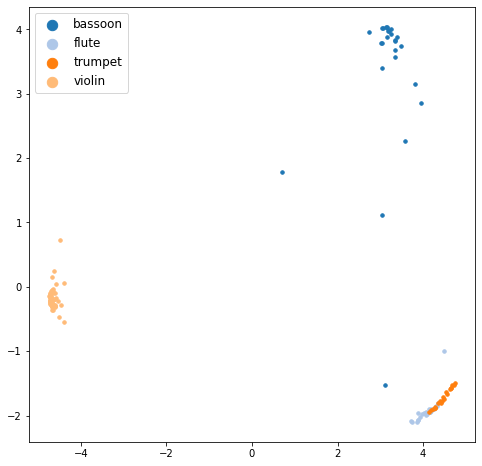

In [21]:
draw_pca(seen_ts_audio_embs, seen_ts_labels, seen_img_classes)

## 2. Unseen class prediction

In [22]:
unseen_img_audio_dataset_tr = ImageAudioDataset(
    audio_path_list = unseen_audio_X_train,
    audio_label_list = unseen_audio_y_train,
    img_path_list = unseen_img_path,
    img_label_list = unseen_img_label,
    img_class_list = unseen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)
unseen_img_audio_dataset_ts = ImageAudioDataset(
    audio_path_list = unseen_audio_X_test,
    audio_label_list = unseen_audio_y_test,
    img_path_list = unseen_img_path,
    img_label_list = unseen_img_label,
    img_class_list = unseen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)

In [23]:
unseen_img_audio_dataloaders = {}
unseen_img_audio_dataloaders['train'] = DataLoader(
    unseen_img_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)
unseen_img_audio_dataloaders['test'] = DataLoader(
    unseen_img_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=False
)

In [24]:
(
    unseen_ts_audio_embs, 
    unseen_random_img_embs, 
    unseen_ts_labels, 
    unseen_ts_loss
) = curr_model.infer_all(unseen_img_audio_dataloaders, 'test')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:12<00:00, 10.45it/s]

test Loss: 0.2749


### 2-1. Computing all image embeddings (unseen classes)

In [25]:
unseen_all_img_embs = []
for i in tqdm(range(len(unseen_img_path))):
    _img = img_transforms['test'](Image.open(unseen_img_path[i])).unsqueeze(0).to(device)
    _img = nn.Sigmoid()(curr_model.model.visual_model(_img))
    _img = torch.squeeze(_img, dim=-1)
    _img = torch.squeeze(_img, dim=-1)
    _img = curr_model.model.visual_projection(_img)
    unseen_all_img_embs.append(_img.squeeze().detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.38it/s]


### 2-2.  Compute the mean image embedding vector for each class

In [26]:
unseen_class_to_img_embs = defaultdict(list)   
for i in tqdm(range(len(unseen_all_img_embs))):
    unseen_class_to_img_embs[unseen_img_label[i]].append(unseen_all_img_embs[i])
unseen_class_to_mean_img_emb = {}
for _c in unseen_class_to_img_embs:
    unseen_class_to_mean_img_emb[_c] = np.mean(unseen_class_to_img_embs[_c], axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 627420.19it/s]


### 2-3. Test set audio of unseen class (mean image embedding) prediction (zero-shot evaluation)

In [27]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                                  unseen_class_to_mean_img_emb, 
                                                  unseen_img_classes,
                                                  1)
    if unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-1 acc : 0.5461538461538461


### 2-4. Unseen class (mean image embedding) to test set audio retrieval (zero-shot evaluation)

In [ ]:
# TODO

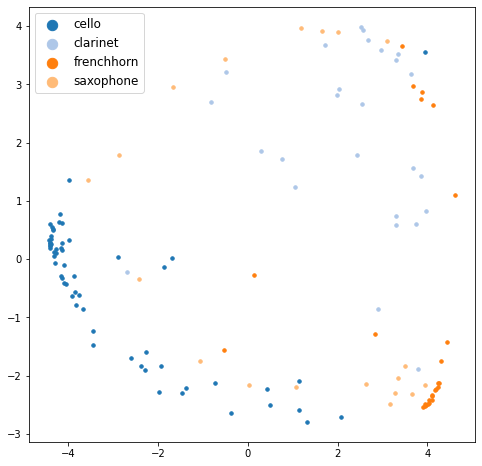

In [28]:
draw_pca(unseen_ts_audio_embs, unseen_ts_labels, unseen_img_classes)

## Generalized ZSL evaluation

In [29]:
all_img_classes = seen_img_classes + unseen_img_classes

In [30]:
all_img_classes

['bassoon',
 'flute',
 'trumpet',
 'violin',
 'cello',
 'clarinet',
 'frenchhorn',
 'saxophone']

In [32]:
added_unseen_ts_labels = [_n + 4 for _n in unseen_ts_labels]
added_unseen_img_label = [_n + 4 for _n in unseen_img_label]

In [33]:
all_ts_audio_embs = np.concatenate([seen_ts_audio_embs, unseen_ts_audio_embs])
all_img_embs = np.concatenate([seen_all_img_embs, unseen_all_img_embs])
all_img_label = seen_img_label + added_unseen_img_label

In [34]:
all_ts_labels = seen_ts_labels + added_unseen_ts_labels

In [35]:
all_class_to_mean_img_emb = {}
for _c, _emb in seen_class_to_mean_img_emb.items():
    all_class_to_mean_img_emb[_c] = _emb
for _c, _emb in unseen_class_to_mean_img_emb.items():
    all_class_to_mean_img_emb[_c+4] = _emb

In [36]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            all_class_to_mean_img_emb, 
                                            all_img_classes,
                                            1)
    if added_unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-1 acc : 0.13076923076923078


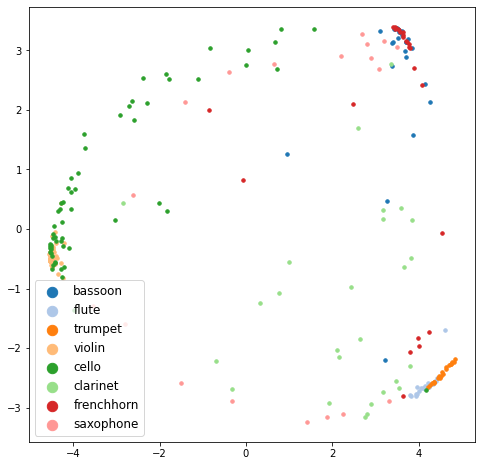

In [37]:
draw_pca(all_ts_audio_embs, all_ts_labels, all_img_classes)

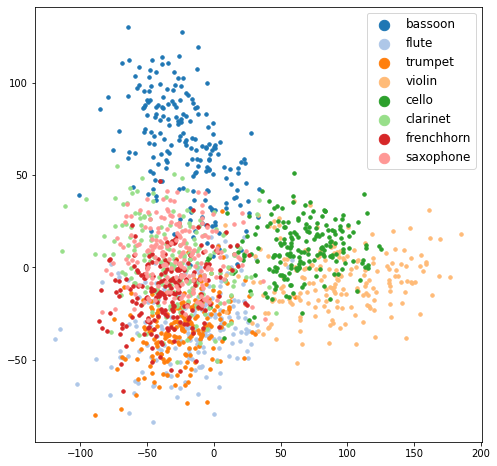

In [38]:
draw_pca(all_img_embs, all_img_label, all_img_classes)